Training images: 21600
Testing images: 5400
Found 17280 images belonging to 10 classes.
Found 4320 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
269/270 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categorical_accuracy: 0.6375 - loss: 1.1916
Epoch 1: val_categorical_accuracy improved from -inf to 0.76481, saving model to /content/working1/best_model_01.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 73s 215ms/step - categorical_accuracy: 0.6379 - loss: 1.1898 - val_categorical_accuracy: 0.7648 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/50
269/270 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - categorical_accuracy: 0.7427 - loss: 0.7613
Epoch 2: val_categorical_accuracy improved from 0.76481 to 0.79282, saving model to /content/working1/best_model_02.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 59s 153ms/step - categorical_accuracy: 0.7427 - loss: 0.7611 - val_categorical_accuracy: 0.7928 - val_loss: 0.6221 - learning_rate: 0.001

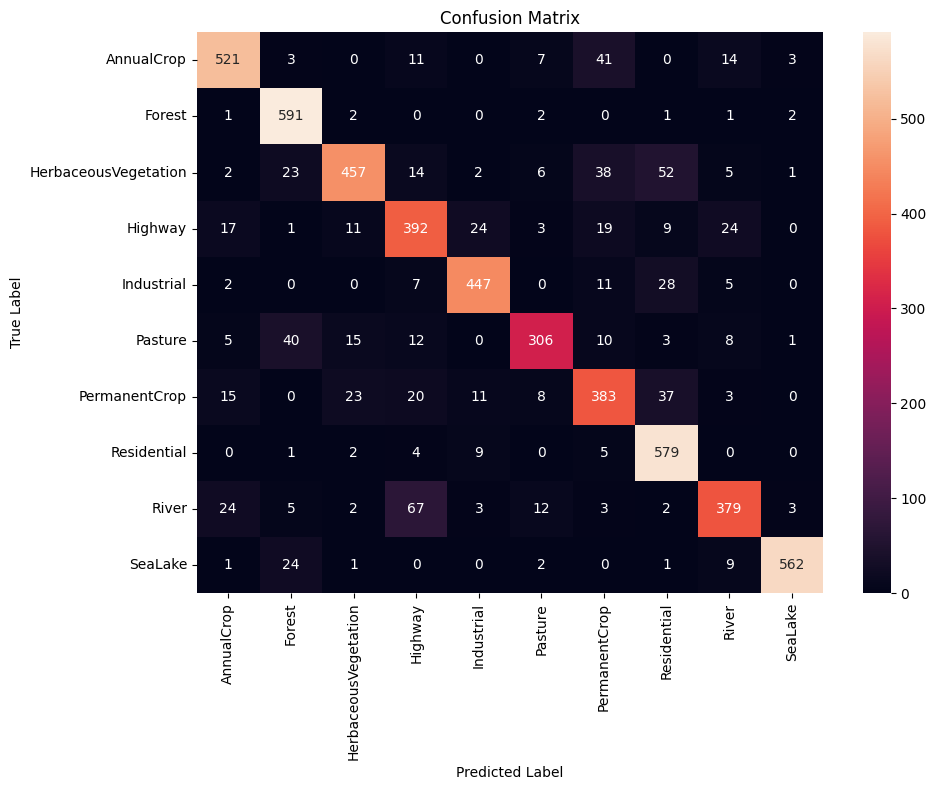

In [5]:

import os
import re
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score


DATASET_PATH = '/content/2750'
TRAIN_DIR = '/content/training1'
TEST_DIR = '/content/testing1'
WORKING_DIR = '/content/working1'

for directory in [TRAIN_DIR, TEST_DIR, WORKING_DIR]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)


def preprocess_data(dataset_path, train_dir, test_dir):

    LABELS = os.listdir(dataset_path)

    for l in LABELS:
        os.makedirs(os.path.join(train_dir, l), exist_ok=True)
        os.makedirs(os.path.join(test_dir, l), exist_ok=True)


    for label in LABELS:

        image_paths = [os.path.join(dataset_path, label, img) for img in os.listdir(os.path.join(dataset_path, label))]


        train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

        for src_path in train_paths:
            dst_path = os.path.join(train_dir, label, os.path.basename(src_path))
            shutil.copy(src_path, dst_path)


        for src_path in test_paths:
            dst_path = os.path.join(test_dir, label, os.path.basename(src_path))
            shutil.copy(src_path, dst_path)

    print(f"Training images: {sum([len(os.listdir(os.path.join(train_dir, label))) for label in LABELS])}")
    print(f"Testing images: {sum([len(os.listdir(os.path.join(test_dir, label))) for label in LABELS])}")

preprocess_data(DATASET_PATH, TRAIN_DIR, TEST_DIR)

BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = len(os.listdir(TRAIN_DIR))


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


class_indices = train_generator.class_indices
np.save(os.path.join(WORKING_DIR, 'class_indices.npy'), class_indices)


def create_resnet_model(input_shape, num_classes):

    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False


    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)


    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model


resnet_model = create_resnet_model(INPUT_SHAPE, NUM_CLASSES)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(WORKING_DIR, 'best_model_{epoch:02d}.keras'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

try:

    first_phase_history = resnet_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    for layer in resnet_model.layers:
        layer.trainable = True


    resnet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )


    fine_tune_history = resnet_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        initial_epoch=len(first_phase_history.history['loss']),
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

except Exception as e:
    print(f"Training interrupted: {e}")
finally:

    final_model_path = os.path.join(WORKING_DIR, 'final_eurosat_model.keras')
    resnet_model.save(final_model_path)
    print(f"Final model saved to: {final_model_path}")

def display_results(y_true, y_preds, class_labels):
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)

    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds),
                            columns=class_labels,
                            index=class_labels)
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat


test_generator.reset()
predictions = resnet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes


class_indices_inv = {v: k for k, v in class_indices.items()}

prf, conf_mat = display_results(true_classes, predicted_classes, list(class_indices_inv.values()))
print(prf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(class_indices_inv.values()),
            yticklabels=list(class_indices_inv.values()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'confusion_matrix.png'))

Epoch 51/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_accuracy: 0.7955 - loss: 0.6544
Epoch 51: val_categorical_accuracy did not improve from 0.84676
270/270 ━━━━━━━━━━━━━━━━━━━━ 105s 178ms/step - categorical_accuracy: 0.7956 - loss: 0.6541 - val_categorical_accuracy: 0.7294 - val_loss: 1.1812 - learning_rate: 2.5000e-04
Epoch 52/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_accuracy: 0.8681 - loss: 0.4126
Epoch 52: val_categorical_accuracy did not improve from 0.84676
270/270 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - categorical_accuracy: 0.8682 - loss: 0.4125 - val_categorical_accuracy: 0.8197 - val_loss: 1.0039 - learning_rate: 2.5000e-04
Epoch 53/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_accuracy: 0.8970 - loss: 0.3234
Epoch 53: val_categorical_accuracy did not improve from 0.84676
270/270 ━━━━━━━━━━━━━━━━━━━━ 80s 154ms/step - categorical_accuracy: 0.8970 - loss: 0.3233 - val_categorical_accuracy: 0.8123 - val_loss: 0.6437 - learning_ra

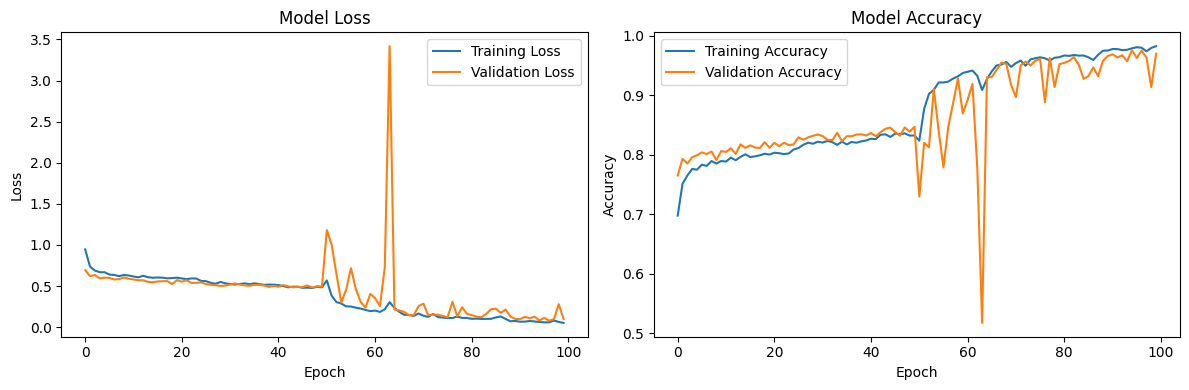

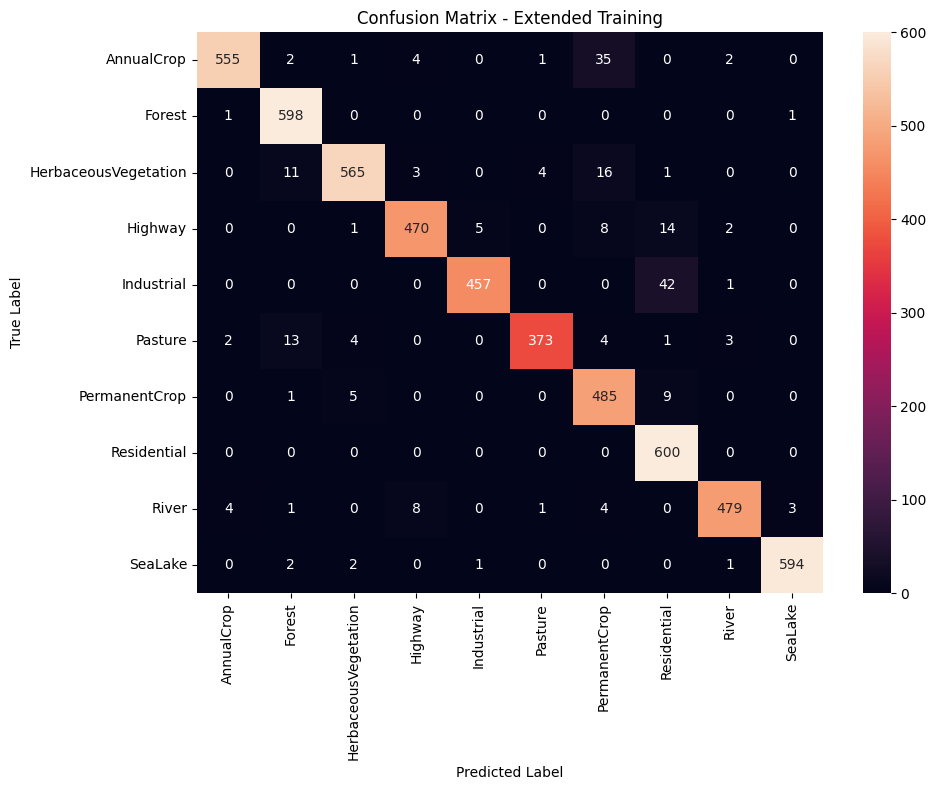

In [8]:

first_phase_loss = first_phase_history.history.get('loss', [])
first_phase_val_loss = first_phase_history.history.get('val_loss', [])
first_phase_accuracy = first_phase_history.history.get('categorical_accuracy', [])
first_phase_val_accuracy = first_phase_history.history.get('val_categorical_accuracy', [])

fine_tune_loss = fine_tune_history.history.get('loss', [])
fine_tune_val_loss = fine_tune_history.history.get('val_loss', [])
fine_tune_accuracy = fine_tune_history.history.get('categorical_accuracy', [])
fine_tune_val_accuracy = fine_tune_history.history.get('val_categorical_accuracy', [])

combined_history = {
    'loss': first_phase_loss + fine_tune_loss,
    'val_loss': first_phase_val_loss + fine_tune_val_loss,
    'categorical_accuracy': first_phase_accuracy + fine_tune_accuracy,
    'val_categorical_accuracy': first_phase_val_accuracy + fine_tune_val_accuracy
}

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2.5e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

try:

    additional_fine_tune_history = resnet_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        initial_epoch=len(combined_history['loss']),
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    for key in ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']:
        if key in additional_fine_tune_history.history:
            combined_history[key].extend(additional_fine_tune_history.history[key])

except Exception as e:
    print(f"Extended training interrupted: {e}")
finally:

    extended_final_model_path = os.path.join(WORKING_DIR, 'final_extended_eurosat_model.keras')
    resnet_model.save(extended_final_model_path)
    print(f"Extended final model saved to: {extended_final_model_path}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['categorical_accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'extended_training_history.png'))

test_generator.reset()
extended_predictions = resnet_model.predict(test_generator)
extended_predicted_classes = np.argmax(extended_predictions, axis=1)
extended_true_classes = test_generator.classes

extended_prf, extended_conf_mat = display_results(extended_true_classes, extended_predicted_classes, list(class_indices_inv.values()))
print("\nExtended Training Results:")
print(extended_prf)

plt.figure(figsize=(10, 8))
sns.heatmap(extended_conf_mat, annot=True, fmt='d',
            xticklabels=list(class_indices_inv.values()),
            yticklabels=list(class_indices_inv.values()))
plt.title('Confusion Matrix - Extended Training')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'extended_confusion_matrix.png'))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/EuroSAT.zip > /dev/null